# Machine learning model for time series forecasting

## using the Random Forest Forecasting model to forecast ESG scores and Revenue

## Modeling Steps:

### 1. Generate 1-year lag features per company

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("ESG_data.csv")

# Sort by company and year
df = df.sort_values(by=["CompanyID", "Year"])

# Define columns for lag features
lag_features = [
    "Revenue", "ESG_Overall", "ProfitMargin", "CarbonEmissions",
    "WaterUsage", "EnergyConsumption", "ESG_Environmental",
    "ESG_Social", "ESG_Governance"
]

# Create 1-year lag features
for col in lag_features:
    df[f"{col}_lag1"] = df.groupby("CompanyID")[col].shift(1)

# Drop rows with missing lag values
df_model = df.dropna(subset=[f"{col}_lag1" for col in lag_features])


### 2. Encode categorical variables

In [3]:
from sklearn.preprocessing import OneHotEncoder

# Use sparse_output for older scikit-learn versions
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(df_model[["Industry", "Region"]])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(["Industry", "Region"]))


### 3. Prepare feature and target matrices



In [4]:
# Final feature list
feature_cols = ["Year"] + [f"{col}_lag1" for col in lag_features]
X = pd.concat([
    df_model[feature_cols].reset_index(drop=True),
    encoded_cat_df.reset_index(drop=True)
], axis=1)

# Targets
y = df_model[["Revenue", "ESG_Overall"]].reset_index(drop=True)

### 4. Train a multi-output Random Forest model



In [5]:
# Train/test split (no shuffle to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42))
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

### 5. Evaluate performance (R², RMSE)



R² Scores -> Revenue: 0.986, ESG_Overall: 0.994
RMSE -> Revenue: 604.41, ESG_Overall: 1.19


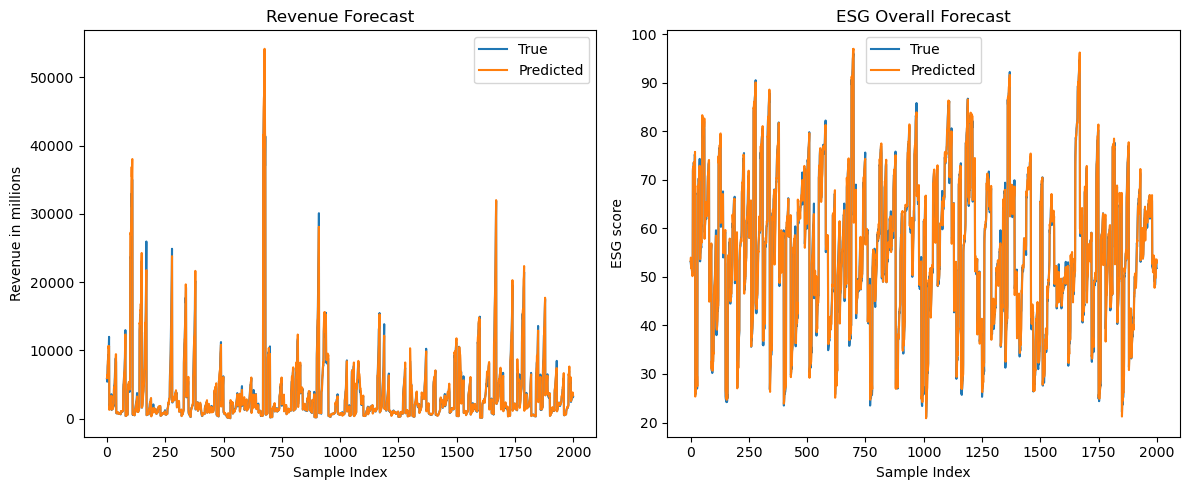

In [7]:
# Evaluate
r2 = r2_score(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

print(f"R² Scores -> Revenue: {r2[0]:.3f}, ESG_Overall: {r2[1]:.3f}")
print(f"RMSE -> Revenue: {rmse[0]:.2f}, ESG_Overall: {rmse[1]:.2f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test["Revenue"].values, label="True")
plt.plot(y_pred[:, 0], label="Predicted")
plt.title("Revenue Forecast")
plt.xlabel("Sample Index")
plt.ylabel("Revenue in millions")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test["ESG_Overall"].values, label="True")
plt.plot(y_pred[:, 1], label="Predicted")
plt.title("ESG Overall Forecast")
plt.xlabel("Sample Index")
plt.ylabel("ESG score")
plt.legend()
plt.tight_layout()
plt.show()

## Forecast ESG scores and Revenue for 2026

In [8]:
# Get 2025 data to use as lag input for 2026 forecast
latest_year_data = df_model[df_model["Year"] == 2025].copy()

# Prepare features as if for 2026
latest_year_data["Year"] = 2026  # set forecast year

# Reuse lag columns (from 2025) and categorical encoding
X_2026 = pd.concat([
    latest_year_data[feature_cols].reset_index(drop=True),
    pd.DataFrame(
        encoder.transform(latest_year_data[["Industry", "Region"]]),
        columns=encoder.get_feature_names_out(["Industry", "Region"])
    ).reset_index(drop=True)
], axis=1)

# Predict 2026 values
pred_2026 = model.predict(X_2026)

# Combine with Company info
forecast_2026 = latest_year_data[["CompanyID", "CompanyName", "Industry", "Region"]].copy()
forecast_2026["Year"] = 2026
forecast_2026["Predicted_Revenue"] = pred_2026[:, 0]
forecast_2026["Predicted_ESG_Overall"] = pred_2026[:, 1]

# Show top 10 results
print(forecast_2026.head(10))


     CompanyID CompanyName        Industry         Region  Year  \
10           1   Company_1          Retail  Latin America  2026   
21           2   Company_2          Retail           Asia  2026   
32           3   Company_3  Transportation  Latin America  2026   
43           4   Company_4      Technology         Africa  2026   
54           5   Company_5         Finance    Middle East  2026   
65           6   Company_6  Transportation        Oceania  2026   
76           7   Company_7      Healthcare        Oceania  2026   
87           8   Company_8      Healthcare         Europe  2026   
98           9   Company_9      Technology  North America  2026   
109         10  Company_10      Technology  Latin America  2026   

     Predicted_Revenue  Predicted_ESG_Overall  
10          709.956378              59.119726  
21         4150.886272              66.529189  
32          443.609196              33.146607  
43         7236.082054              64.154460  
54         3309.058521